<a href="https://colab.research.google.com/github/Alok180804/MajorProject/blob/main/NetravathiRiver_1980_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Merged_Sediment_Discharge_Data.csv to Merged_Sediment_Discharge_Data.csv


In [4]:
df = pd.read_csv("Merged_Sediment_Discharge_Data.csv")

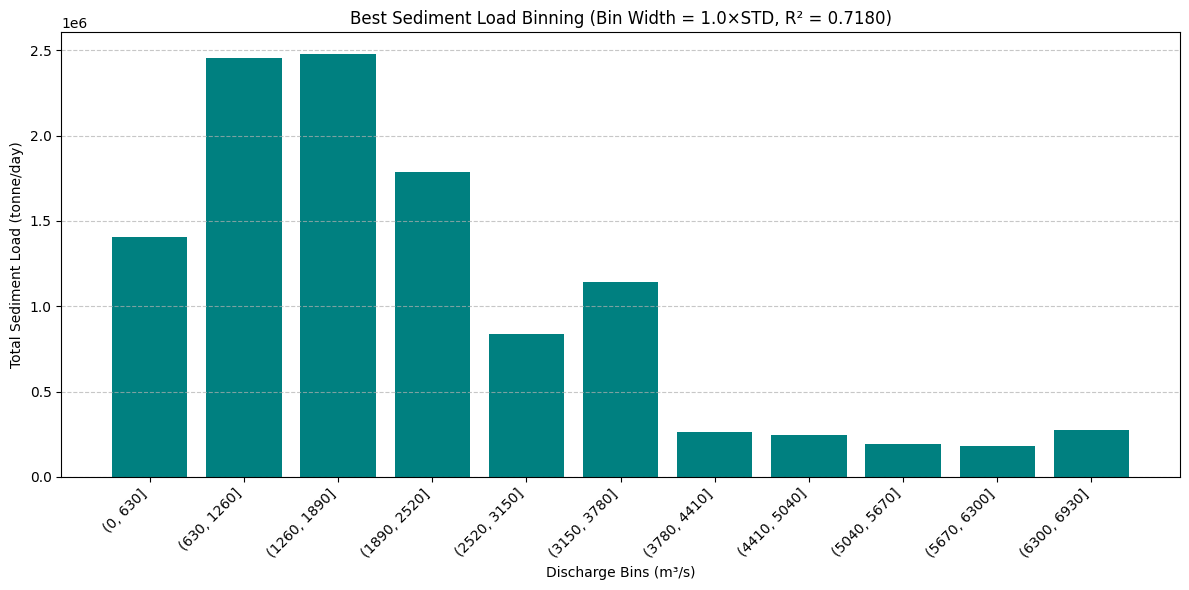

In [6]:
def bin_and_evaluate(df, multiples=[1.0, 0.75, 0.5, 0.25]):
    std_discharge = df['Discharge_m3_s'].std()
    best_result = None
    highest_r2 = -float('inf')

    for multiple in multiples:
        bin_width = std_discharge * multiple
        max_discharge = int((df['Discharge_m3_s'].max() // bin_width + 1) * bin_width)
        bins = list(range(0, int(max_discharge + bin_width), int(bin_width)))

        # Assign bins
        df['Discharge_Bin'] = pd.cut(df['Discharge_m3_s'], bins=bins)

        # Group sediment
        binned_df = df.groupby('Discharge_Bin', observed=True)['Sediment_tonne_day'].sum().reset_index()
        binned_df.columns = ['Discharge_Bin', 'Total_Sediment_tonne_day']

        # Midpoints for regression
        midpoints = binned_df['Discharge_Bin'].apply(lambda x: (x.left + x.right)/2).values.reshape(-1, 1)
        sediment = binned_df['Total_Sediment_tonne_day'].values

        # Linear regression & R²
        model = LinearRegression().fit(midpoints, sediment)
        r2 = r2_score(sediment, model.predict(midpoints))

        if r2 > highest_r2:
            highest_r2 = r2
            best_result = {
                'multiple': multiple,
                'binned_df': binned_df,
                'bins': bins,
                'r2': r2
            }

    return best_result

# Load data
df = pd.read_csv("Merged_Sediment_Discharge_Data.csv")

# Run the automated binning evaluation
best = bin_and_evaluate(df)

# Plot the best result
plt.figure(figsize=(12, 6))
plt.bar(best['binned_df']['Discharge_Bin'].astype(str), best['binned_df']['Total_Sediment_tonne_day'], color='teal')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Discharge Bins (m³/s)")
plt.ylabel("Total Sediment Load (tonne/day)")
plt.title(f"Best Sediment Load Binning (Bin Width = {best['multiple']}×STD, R² = {best['r2']:.4f})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()